Introduction :


*   My Project is A Real Time Face Mask Detection which detect wether 
    person is wearnig a mask , not wearing it or wearing it incorrectly.

*   The Model used in this Project is a yolov5 model fine tuned with my 
    own dataset and experiments untill reaching the best score.

*   The Notebook contains data section , training and validation section and Real time detection section

*   In real time detection section we can detect wether person is wearning mask or not using the pc webcam.





## libraries and dependencies

In [1]:
!pip install youtube_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.2 MB/s eta 0:00:00


In [2]:
#@title Importing libraries and dependencies
import xml.etree.ElementTree as ET
import os
from distutils.dir_util import copy_tree
import torch
from shutil import copyfile
import numpy as np
import cv2
import time
from IPython.display import display , Javascript , Image , clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
from matplotlib import pyplot as plt

# Preparing the dataset and Converting it to the yolov5 format

Dataset Information :

1.   Original Dataset link : https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
2.   the original dataset contains 853 images belonging to the 3 
     classes, as well as their bounding boxes in the PASCAL VOC format.
3.   images are taken in real life in corona virus pandemic time





4.   Data Preprocessing and Augmentation:

     Data Versions : 
        1. Dataset v1:
            1.   used roboflow website
            2.   applied data preprocessing steps :
                 1. applied auto orientation to save the photo whether
                    the camera is oriented in landscape or portrait mode
                 2. compress all images to 500x500 size where the 
                    needed details have the least needed visiblity
            3.   applied data augmentation steps:
                 1. Saturation: Between -12% and +12%
                 2. Brightness: Between -22% and +22%
                 3. Blur: Up to 1px
                 4. Noise: Up to 2% of pixels
                 5. these variations have trippled the dataset records
            4.   convert the data from pascal voc type to yolo .yaml 
                 type to use it in training and testing the model
            5.   80% train , 20% test.
            6.   number of records = 2200

        2. Dataset v2:
            1.   used roboflow website
            2.   applied data preprocessing steps :
                 1. applied auto orientation to save the photo whether
                    the camera is oriented in landscape or portrait mode
                 2. compress all images to 500x500 size where the 
                    needed details have the least needed visiblity
            3.   applied data augmentation steps:
                 1. Saturation: Between -12% and +12%
                 2. Brightness: Between -22% and +22%
                 3. Blur: Up to 1px
                 4. Noise: Up to 2% of pixels
                 5. these variations have trippled the dataset records
                 6. applied cropping to boundary boxes
            4.   convert the data from pascal voc type to yolo .yaml 
                 type to use it in training and testing the model
            5.   70% train , 20% validation , 10% test.
            6.   number of records : 9856 ,but there were much 
                 corrupted files so i ignored this version after 1 experiment.

        2. Dataset v3:
            1.   used roboflow website
            2.   applied data preprocessing steps :
                 1. applied auto orientation to save the photo whether
                    the camera is oriented in landscape or portrait mode
            3.   applied data augmentation steps:
                 1. Saturation: Between -69% and +69%
                 2. Brightness: Between -29% and +29%
                 3. Blur: Up to 1.5px
                 4. Noise: Up to 5% of pixels
                 5. added some external data from kaggle and take 
                    videos and images and annotate them manually to balance the classes and instances.
            4.   used the data as yolov5 format.
            5.   72% train , 20% validation , 8% test.
            6.   number of records : 5943

        4. Dataset v4:
            1.   used roboflow website
            2.   applied data preprocessing steps :
                 1. applied auto orientation to save the photo whether
                    the camera is oriented in landscape or portrait mode
            3.   applied data augmentation steps:
                 1. Saturation: Between -25% and +25%
                 2. Blur: Up to 2.5px
                 4. Noise: Up to 5% of pixels
                 5. added some external data from kaggle and take 
                    videos and images and annotate them manually to balance the classes and instances , balanced more than v3.
            4.   used the data as yolov5 format.
            5.   70% train , 20% validation , 10% test.
            6.   number of records : 5798


In [ ]:
#@title Retreiving the dataset from drive

os.mkdir('train')
os.mkdir('test')
os.mkdir('val')
copy_tree( '/content/drive/MyDrive/Amit Project/face mask detection data v2/train/images', './train/images')
copy_tree( '/content/drive/MyDrive/Amit Project/face mask detection data v2/test/images', './test/images')
copy_tree( '/content/drive/MyDrive/Amit Project/face mask detection data v2/valid/images', './val/images')

In [ ]:
#@title Extracting information from train annotations files to txt files with the needed info ( class , x center , y center , width , height )
train_annotations = '/content/drive/MyDrive/Amit Project/face mask detection data v2/train/annotations'
os.mkdir('train/labels')


# extracting the information from the train annotations files
for file_ in os.listdir(train_annotations):
  path = os.path.join(train_annotations,file_)

  tree = ET.parse(path)
  root = tree.getroot()
  # getting the file name
  file = root[1].text

  width = int(root[4][0].text)
  height = int(root[4][1].text)
  
  # initiating the classes mapping
  classes = {'without_mask' : 0 , 'mask_weared_incorrect' : 1 , 'with_mask' : 2}

  lines = '' 
  for i, child in enumerate(root):
    if child.tag == 'object':
      class_ = root[i][0].text
      x1 , x2 , y1 , y2 = int(root[i][5][0].text) , int(root[i][5][1].text) , int(root[i][5][2].text) , int(root[i][5][3].text)
      
      # getting the x center and y center
      x , y = (((x2-x1)/2)+x1)/width , (((y2-y1)/2)+y1) / height
      # getting the width and the height
      w , h = (x2-x1)/width , (y2-y1)/height
      # writing the information in the format of yolo data
      line = f'{classes[class_]} {x} {y} {w} {h} \n'
      lines += line
  
  # creating the new txt files for annotations and saving them
  with open(f"train/labels/{file.replace('.png' , '.txt').replace('.jpeg','.txt').replace('.jpg' , '.txt')}" , "w") as f:
    f.write(lines)



In [ ]:
#@title Extracting information from val annotations files to txt files with the needed info ( class , x center , y center , width , height )
val_annotations = '/content/drive/MyDrive/Amit Project/face mask detection data v2/valid/annotations'
os.mkdir('val/labels')


# extracting the information from the train annotations files
for file_ in os.listdir(val_annotations):
  path = os.path.join(val_annotations,file_)

  tree = ET.parse(path)
  root = tree.getroot()
  # getting the file name
  file = root[1].text

  width = int(root[4][0].text)
  height = int(root[4][1].text)
  
  # initiating the classes mapping
  classes = {'without_mask' : 0 , 'mask_weared_incorrect' : 1 , 'with_mask' : 2}

  lines = '' 
  for i, child in enumerate(root):
    if child.tag == 'object':
      class_ = root[i][0].text
      x1 , x2 , y1 , y2 = int(root[i][5][0].text) , int(root[i][5][1].text) , int(root[i][5][2].text) , int(root[i][5][3].text)
      
      # getting the x center and y center
      x , y = (((x2-x1)/2)+x1)/width , (((y2-y1)/2)+y1) / height
      # getting the width and the height
      w , h = (x2-x1)/width , (y2-y1)/height
      # writing the information in the format of yolo data
      line = f'{classes[class_]} {x} {y} {w} {h} \n'
      lines += line
  
  # creating the new txt files for annotations and saving them
  with open(f"val/labels/{file.replace('.png' , '.txt').replace('.jpeg','.txt').replace('.jpg' , '.txt')}" , "w") as f:
    f.write(lines)


In [ ]:
#@title Extracting information from test annotations files to txt files with the needed info ( class , x center , y center , width , height )
test_annotations = '/content/drive/MyDrive/Amit Project/face mask detection data v2/test/annotations'
os.mkdir('/content/test/labels')

# extracting the information from the test annotations files
for file_ in os.listdir(test_annotations):
  path = os.path.join(test_annotations,file_)

  tree = ET.parse(path)
  root = tree.getroot()
  # getting the file name
  file = root[1].text

  width = int(root[4][0].text)
  height = int(root[4][1].text)
  
  # initiating the classes mapping
  classes = {'without_mask' : 0 , 'mask_weared_incorrect' : 1 , 'with_mask' : 2}

  lines = '' 
  for i, child in enumerate(root):
    if child.tag == 'object':
      class_ = root[i][0].text
      x1 , x2 , y1 , y2 = int(root[i][5][0].text) , int(root[i][5][1].text) , int(root[i][5][2].text) , int(root[i][5][3].text)
      
      # getting the x center and y center
      x , y = (((x2-x1)/2)+x1)/width , (((y2-y1)/2)+y1) / height
      # getting the width and the height
      w , h = (x2-x1)/width , (y2-y1)/height
      # writing the information in the format of yolo data
      line = f'{classes[class_]} {x} {y} {w} {h} \n'
      lines += line
  
  # creating the new txt files for annotations and saving them
  with open(f"test/labels/{file.replace('.png' , '.txt').replace('.jpeg','.txt').replace('.jpg' , '.txt')}" , "w") as f:
    f.write(lines)

In [3]:
#@title Downloading the yolov5 version and its requirements
!git clone https://github.com/ultralytics/yolov5   
%cd yolov5
%pip install -qr requirements.txt
%pip install -q wandb
!wandb disabled

Cloning into 'yolov5'...
remote: Enumerating objects: 15692, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15692 (delta 5), reused 8 (delta 3), pack-reused 15672
Receiving objects: 100% (15692/15692), 14.48 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (10746/10746), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.5/586.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
W&B disabled.


In [ ]:
#@title Making the yaml yolo data format 
data = """
train: /content/train/images # train images (relative to path)
test: /content/test/images   # test images (relative to path)
val: /content/val/images   # val images (relative to path)

# Classes
nc: 3  # number of classes
names: ['without_mask' , 'incorrect_weared_mask' , 'with_mask']  # class names

"""

with open('data/custom_data.yaml','w') as w:
  w.write(data)

In [4]:
#@title this cell for downloading dataset v3 yolo format

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="i4fTrr4NqNGTS5rSR2uB")
project = rf.workspace("face-mask-detection-aarne").project("face-mask-detection-tmy8p")
dataset = project.version(1).download(model_format = 'yolov5' , location = '/content/yolov5/data/Dataset')
!pip install roboflow





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=df72b3705b99554777fcc60a33b627f376c17eb6c8c446a8df38ec189203b05c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to /content/yolov5/data/Dataset in yolov5pytorch:: 100%|██████████| 8698/8698 [00:02<00:00, 2973.74it/s]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Training & Validation Procedure

Training Information : 


1.   1st model used : basic CNN on other data got accuracy 92% ,
     then i used yolov5 model where it proved the best performance and results in object detection tasks , 
     i fine tuned the model on my Dataset to transfer learning from the yolov5 weights rather than train model from scratch to save time , resources and the dataset was small also to train model from scratch.
2.   Expirements :
     1. experiment 1 :
        * data version : v1
        * image size = 500
        * epochs = 40
        * batch size = 32
        * output :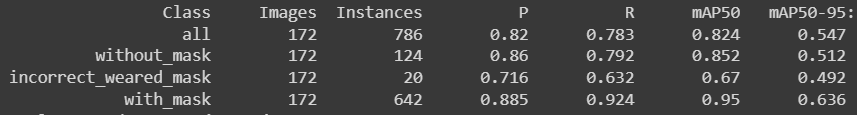

     2. experiment 2 :  
        * data version : v2 
        * image size = 128
        * epochs = 50
        * batch size = 16
        * output : 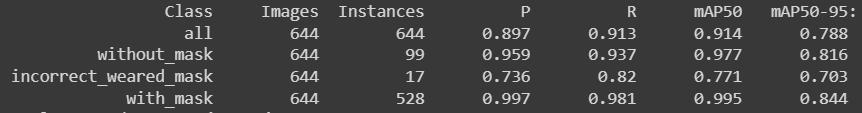

     3. experiment 3 :  
        * dataset version : v3 
        * image size = 640
        * epochs = 50
        * batch size = 8
        * output : 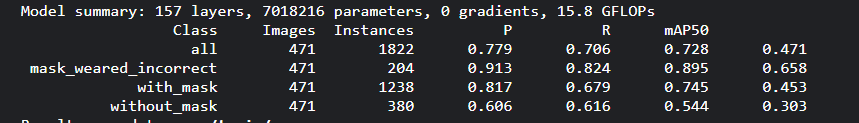

     4. experiment 4 :  
        * dataset version : v4
        * image size = 640
        * epochs = 50
        * batch size = 16
        * output : 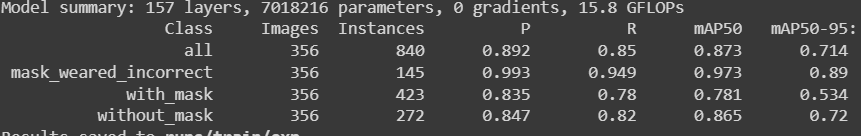

In [8]:
#@title Training
!python train.py --img 640 --batch 16 --epochs 40 --data /content/yolov5/data/Dataset/data.yaml --weights yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/data/Dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005,

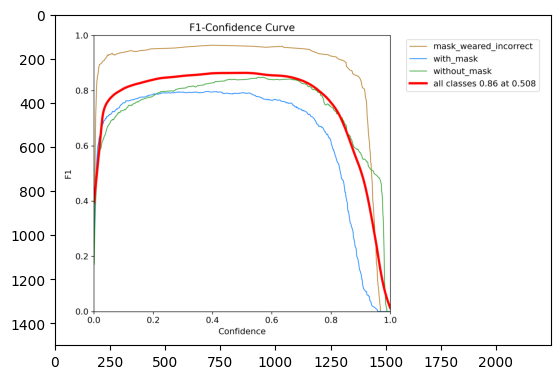

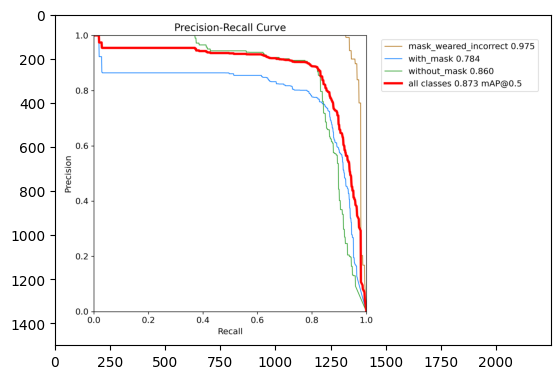

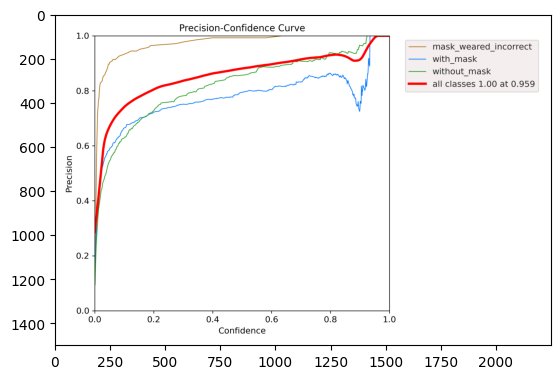

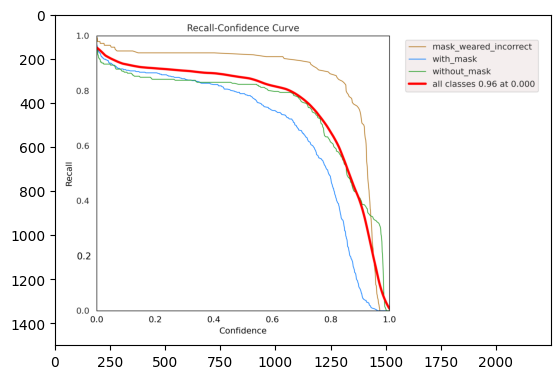

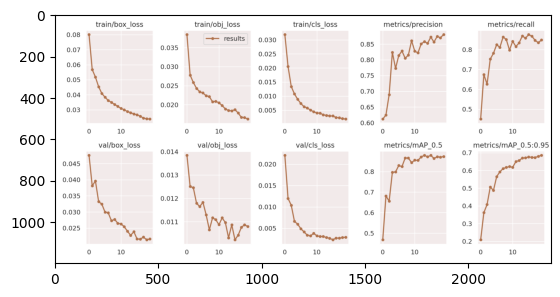

In [6]:
#@title Plotting curves of training procedure
F1_curve = cv2.imread('/content/yolov5/runs/train/exp2/F1_curve.png')
PR_curve = cv2.imread('/content/yolov5/runs/train/exp2/PR_curve.png')
P_curve = cv2.imread('/content/yolov5/runs/train/exp2/P_curve.png')
R_curve = cv2.imread('/content/yolov5/runs/train/exp2/R_curve.png')
results = cv2.imread('/content/yolov5/runs/train/exp2/results.png')

plt.imshow(F1_curve)
plt.show()
plt.imshow(PR_curve)
plt.show()
plt.imshow(P_curve)
plt.show()
plt.imshow(R_curve)
plt.show()
plt.imshow(results)
plt.show()


## Saving the best Model

In [7]:
copyfile('/content/yolov5/runs/train/exp2/weights/best.pt','/content/best.pt')

'/content/best.pt'

In [ ]:
#@title Testing Model on new Images
!python detect.py --weights best.pt  --conf .4 --img-size 640 --source 

# Using the model on Real time Detection

In [ ]:
#@title Helper Functions for Real Time Detection with webcam provided by google colab
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data



In [ ]:
#@title Real Time Object Detection Class
class ObjectDetection:
  
  def __init__(self):
    self.model = self.load_model()
    self.Classes = self.model.names
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("\n\nDevice Used: " , self.device)

  
  def load_model(self):
    """ this function loads the trained model to use it """ 
    model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt', force_reload=True)
    #model = torch.hub.load('path for yolov5','custom', path='best.pt',force_reload=True,source='local', pretrained =False)
    return model

  
  def score_frame(self,frame):
    """ this function takes single frame and score it """
    self.model.to(self.device)
    frame = [frame]
    results = self.model(frame)
    labels , cord = results.xyxyn[0][:,-1] , results.xyxyn[0][: , :-1]
    return labels , cord

  def class_to_label(self , x):
    """ this class mapp the class to string label"""
    return self.Classes[int(x)]


  def plot_boxes(self , results ,frame , bboxarray):
    """ this functions plot the boxes with results in each frame """
    labels , cord = results
    n = len(labels)
    x_shape , y_shape = frame.shape[1] , frame.shape[0]
    for i in range(n):
      row = cord[i]
      if row[4] >= 0.2:
        x1 , y1 , x2 , y2 = int(row[0]*x_shape) , int(row[1]*y_shape) , int(row[2]*x_shape) , int(row[3]*y_shape)
        bgr = (0,255,0)
        bboxarray = cv2.rectangle(bboxarray,(x1,y1) , (x2 , y2) , bgr , 2) 
        bboxarray = cv2.putText(bboxarray , self.class_to_label(labels[i]) , (x1 , y1) , cv2.FONT_HERSHEY_COMPLEX , 1 , (255, 0, 0) , 2 , cv2.LINE_AA)
    return bboxarray


  def __call__(self):
    """ this function called when class excuted """
    # start streaming video from webcam
    video_stream()
    # label for video
    label_html = 'Capturing...'
    bbox = ''
    count = 0
    while True:
       js_reply = video_frame(label_html, bbox)
       if not js_reply:
          break
       
       bbox_array = np.zeros([480,640,4], dtype=np.uint8)
       frame = js_to_image(js_reply["img"])
       results = self.score_frame(frame)
       bbox_array = self.plot_boxes(results , frame , bbox_array)
       bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
       bbox_bytes = bbox_to_bytes(bbox_array)
       bbox = bbox_bytes

In [ ]:
#@title Executing the Real Time Face Mask Detection

# Create an object from the class and execute
detection = ObjectDetection()
detection()

You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-18 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.


Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 




Device Used:  cuda


<IPython.core.display.Javascript object>